In [1]:
import csv
import os
import pandas as pd
import seaborn as sns
from pathlib import Path

In [2]:
def get_experiment_dataframe(experiment_csv_folder_path):
    path = experiment_csv_folder_path
    # or unix / linux / mac path

    # Get the files from the path provided in the OP
    files = Path(path).glob('*.csv')  # .rglob to get subdirectories

    # for f in files:
    #     print(f.stem)


    dfs = list()
    for f in files:
        data = pd.read_csv(f, index_col="id", header=0)
        # .stem is method for pathlib objects to get the filename w/o the extension
        data['file'] = f.stem
        dfs.append(data)

    exp_df = pd.concat(dfs, ignore_index=False)
    exp_df['setting'] = 'W' + exp_df['warmup_epochs'].astype(str) + "-INT" + exp_df['interval_epochs'].astype(str)
    return exp_df


def get_top_n_settings(experiment_dataframe, n=5):

    #standard deviation is rounded to 3 decimal places
    means = experiment_dataframe.groupby(['warmup_epochs', 'interval_epochs'])[
        'best_accuracy'].mean().round(3)

    list_of_settings = []
    for setting, i in means.nlargest(n).items():
        list_of_settings.append(setting)
    return list_of_settings


def output_latex_table_content(experiment_dataframe, output_file_name):

    #standard deviation is rounded to 3 decimal places
    means = experiment_dataframe.groupby(['warmup_epochs', 'interval_epochs'])[
        'best_accuracy'].mean().round(3)
    stds = experiment_dataframe.groupby(['warmup_epochs', 'interval_epochs'])[
        'best_accuracy'].std().round(3)

    table_values = means.astype(str) + "$\pm$" + stds.astype(str)

    warmups = [10, 15, 20, 30, 40, 60]
    intervals = [1, 5, 8, 10, 15, 30]
    table_latex_string = ""
    for warmup in warmups:
        table_latex_string += f"{warmup}"
        for interval in intervals:
            table_latex_string += "& " + f"{table_values[warmup][interval]}"
            if interval == 30:
                table_latex_string += " \\\\ \n"

    with open(output_file_name, "w") as text_file:
        text_file.write(table_latex_string)


In [3]:
# baselines statistics
def get_baselines_stats(baseline_csvs_folder_path):

    path = baseline_csvs_folder_path

    # Get the files from the path provided in the OP
    files = Path(path).glob('*.csv')  # .rglob to get subdirectories


    dfs = list()
    for f in files:
        data = pd.read_csv(f, index_col="id", header=0)
        # .stem is method for pathlib objects to get the filename w/o the extension
        data['file'] = f.stem
        dfs.append(data)

    baselines_df = pd.concat(dfs, ignore_index=False)
    baselines_df['setting'] = "vanilla"


    #standard deviation is rounded to 3 decimal places
    baselines_means = baselines_df.groupby(['dataset', 'model'])[
        'best_accuracy'].mean().round(3)
    baselines_stds = baselines_df.groupby(['dataset', 'model'])[
        'best_accuracy'].std().round(3)
    return baselines_df, baselines_means, baselines_stds



In [4]:
def get_plot_df(model, dataset, experiment_df, baselines_df, number_of_experiments=5):    
    plot_df = baselines_df[(baselines_df["model"] == model) & (
        baselines_df["dataset"] == dataset)]
    top_settings = get_top_n_settings(experiment_df, n=number_of_experiments)
    for (warmup, interval) in top_settings:
        setting_df = experiment_df[(experiment_df['warmup_epochs'] == warmup) & (experiment_df['interval_epochs'] == interval)]
        plot_df = plot_df.append(setting_df)
    return plot_df
    # sns.set_style("whitegrid")
    # box_plot = sns.boxplot(data=plot_df, x="setting",
    #                     y="best_accuracy")

In [5]:
def draw_plot(model, dataset, experiment_folder_path):

    exp_df = get_experiment_dataframe(experiment_folder_path)
    baselines_df, baselines_means, baselines_stds = get_baselines_stats(
        "PaperCSVs/Baselines")
    sns.set_style("whitegrid")
    plot_df = get_plot_df(model, dataset, experiment_df=exp_df, baselines_df=baselines_df, )
    box_plot = sns.boxplot(data=plot_df, x="setting",
                           y="best_accuracy", 
                           showmeans=True,
                           meanprops={
                               "marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}
                           )

    filename = experiment_folder_path.partition("/")[2] + ".pdf"
    box_plot.get_figure().savefig(filename)
    del box_plot
    # return plot_df

# offset from median for display
# vertical_offset = exp_df['best_accuracy'].median() * 0.05

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,mean_values[xtick] + 0.003 , [xtick], 
#             horizontalalignment='center',size='x-small',color='b',weight='semibold')

In [6]:
list_of_workload_paths = ["PaperCSVs/CIFAR10-ResNet18-Blocks-Variance",
                          "PaperCSVs/CIFAR10-ResNet18-Stripes-Average",
                          "PaperCSVs/CIFAR10-ResNet18-Stripes-Variance",
                          "PaperCSVs/CIFAR10-ResNet34-Stripes-Variance",
                          "PaperCSVs/CIFAR100-ResNet34-Stripes-Variance",
                          ]

/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

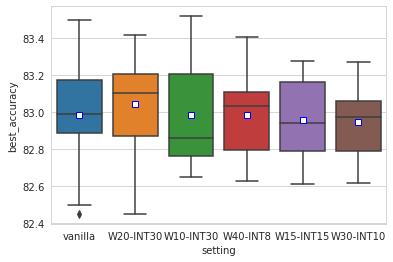

In [7]:
# Figure 5 (1)

path = "PaperCSVs/CIFAR10-ResNet18-Stripes-Variance"
draw_plot("resnet18", "cifar10", path)

/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

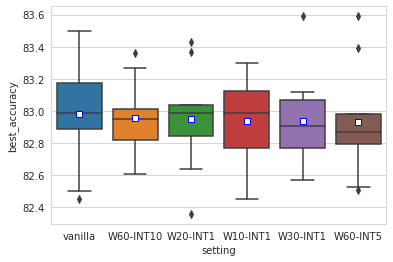

In [8]:
# Figure 5 (2)

path = "PaperCSVs/CIFAR10-ResNet18-Stripes-Average"
draw_plot("resnet18", "cifar10", path)

/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

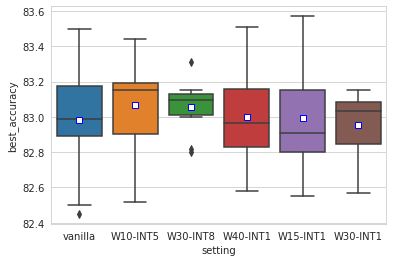

In [9]:
# Figure 5 (3)

path = "PaperCSVs/CIFAR10-ResNet18-Blocks-Variance"
draw_plot("resnet18", "cifar10", path)

/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

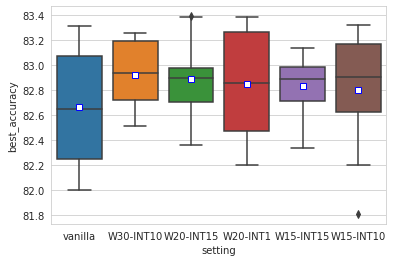

In [10]:
# Figure 5 (4)

path = "PaperCSVs/CIFAR10-ResNet34-Stripes-Variance"
draw_plot("resnet34", "cifar10", path)

/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(setting_df)
/tmp/ipykernel_14940/2311284029.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

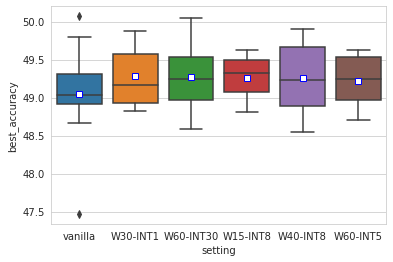

In [11]:
# Figure 5 (5)
path = "PaperCSVs/CIFAR100-ResNet34-Stripes-Variance"
draw_plot("resnet34", "cifar100", path)


In [1]:
# ONLY RUN THIS CELL IF YOU WANT TO FETCH RESULTS FROM YOUR WANDB PROJECT
# in that case, replace the folder name, regex, etc. with your own settings
import wandb

api = wandb.Api(timeout=19)
entity_project_string = "YOUR_WORKSPACE/YOUR_PROJECT"


def get_wandb_csv(folder_name=None, experiment_names_regex=None, baseline=False):
    # CHANGE THE REGEX HERE
    experiment_names_regex = experiment_names_regex

    # apparently returns in order of recency
    # 31 runs -> 9.1 seconds
    runs = api.runs(
        path=entity_project_string,
        filters={'display_name': {"$regex": experiment_names_regex}}
    )

    dict_accuracies = {}
    dict_configs = {}
    for run in runs:
        list_acc = []
        list_configs = [run.config[k] for k in ['warmup_epochs', 'interval_epochs',
                                                'measure', 'heuristic', 'model', 'dataset']]  # to double check correct hyperparams
        if run.state == "finished":
            for i, row in run.history(keys=["test_accuracy"]).iterrows():
                list_acc.append(row["test_accuracy"])
            dict_accuracies[run.id] = list_acc
            dict_configs[run.id] = list_configs

    dict_best_accuracy = {}

    for run_id in dict_accuracies:
        accuracies = dict_accuracies[run_id]
        best_accuracy = max(accuracies)
        # +1 for epoch numbering
        print(
            f"Best Accuracy for {run_id} is {max(accuracies)} at epoch {accuracies.index(best_accuracy)+1}")
    
    if baseline:
        csv_file_name = folder_name + "/" + \
            experiment_names_regex.partition("###T100-")[0] + ".csv"
    else:
        shortened_name = experiment_names_regex.partition("###T100-")[2][:-1]
        shortened_name = shortened_name.partition(
            "IG5-")[0] + shortened_name.partition("IG5-")[2]
        csv_file_name = folder_name + "/" + shortened_name + ".csv"

    num_epochs = len(list_acc)

    header = [f"epoch_{i}" for i in range(1, num_epochs+1)]

    header.insert(0, 'id')
    header = header+['best_accuracy', 'best_epoch'] + ['warmup_epochs',
                                                       'interval_epochs', 'measure', 'heuristic', 'model', 'dataset']

    
    with open(csv_file_name, mode='x') as csv_file:
        csv_writer = csv.writer(
            csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        # write the header
        csv_writer.writerow(header)

        for run_id in dict_accuracies:
            accuracies = dict_accuracies[run_id]
            config = dict_configs[run_id]
            best_accuracy = max(accuracies)
            best_epoch = accuracies.index(best_accuracy) + 1
            # +1 for epoch numbering
            row = [run_id] + accuracies + [best_accuracy, best_epoch] + config
            csv_writer.writerow(row)

master_folder_name = "PaperCSVs"
experiment_group = "CIFAR100-ResNet34-Stripes-Variance"
base_regex = "c100-resnet34###T100-"

warmups = [10, 15, 20, 30, 40, 60]
intervals = [1, 5, 8, 10, 15, 30]

list_regexes = []

for warmup in warmups:
    for interval in intervals:
        list_regexes.append(base_regex+f"W{warmup}-IG5-INT{interval}-")

# print(list_regexes)
# len(list_regexes)

if not os.path.exists(master_folder_name):
    os.mkdir(master_folder_name)

if not os.path.exists(master_folder_name+"/"+experiment_group):
    os.mkdir(master_folder_name+"/"+experiment_group)

for regex in list_regexes:
    get_wandb_csv(folder_name=master_folder_name+"/" +
                  experiment_group, experiment_names_regex=regex)

# get baseline (vanilla) CSVs
vanilla_regexes = ["c10-vanilla-resnet18-batch256###T100-",
                   "c10-vanilla-resnet34-total100###T100-",
                   "c100-vanilla-resnet34-total100###T100-",
                   ]

if not os.path.exists("Baselines"):
    os.mkdir("Baselines")

for regex in vanilla_regexes:
    get_wandb_csv(folder_name="Baselines", experiment_names_regex=regex, baseline=True)
    